## TCGA Analysis
- training 1 post-inference.
- Generate curves in 5a along with 95% confidence intervals for AUC.

#### Statistical significante of ROC
- DeLong test for statistical significance of ROCAUC [link](https://www.jstor.org/stable/2531595?seq=1)
- DeLong test in Python [link](https://biasedml.com/roc-comparison/)
- Bootstrapping ROC for estimating error [StackOverflow](https://stackoverflow.com/questions/19124239/scikit-learn-roc-curve-with-confidence-intervals).

In [ ]:
import re
from tommy_library import *

In [17]:
import pandas as pd
import numpy as np
import os
import glob

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from scipy.stats import entropy
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import metrics

In [18]:
home = os.getenv("HOME")

In [19]:
'Load metadata'
fld = os.path.join(home, 'disks')
data_fld = '../data'
sub_fld = os.path.join(data_fld, 'TCGA_data')
path = os.path.join(sub_fld, 'tcga_wsi_meta.csv')
df_wsi = pd.read_csv(path, index_col=0)
path = os.path.join(sub_fld, 'tcga_tile_meta.csv')
df_tile = pd.read_csv(path)

In [20]:
# removes, acral, acral/non-cutaneous and NAs

df_wsi = df_wsi[df_wsi.primary_tumor_type == 'NON-ACRAL CUTANEOUS']
df_tile = df_tile[df_tile.primary_tumor_type == 'NON-ACRAL CUTANEOUS']

In [21]:
path = os.path.join(sub_fld, '0107_pred_TCGA_2.csv')
df_tst = pd.read_csv(path, index_col=0)

In [22]:
'Remove uncertain prediction from further analysis'
mask = df_tst.uncertain == False
df_tst = df_tst[mask]

In [23]:
df_tst = df_tst[df_tst.primary_tumor_type == 'NON-ACRAL CUTANEOUS']

In [24]:
df_tst

,Unnamed: 0,wsi_id,x_tile_coord,y_tile_coord,clinical_donor_id,wsi_name,clinical_sample_id,primary_tumor_type,CNA_data,ABSOLUTE_purity,...,PTEN_prob,APC_prob,APC_BC,OxPhos,APC_OxPhos,APC_BC_OxPhos,P53_MITF,P53_Co,P53_MITF_Co,MITF_Co
0,2,TCGA-EE-A3JD-01Z-00-DX1.svs,1,8,TCGA-EE-A3JD,TCGA-EE-A3JD-01Z-00-DX1.D4E5B644-C7EF-442D-91F...,TCGA-EE-A3JD-06,NON-ACRAL CUTANEOUS,True,0.26,...,1.858032e-14,1.000000,0,False,False,False,True,True,True,True
2,5,TCGA-EE-A2MK-01Z-00-DX1.svs,8,6,TCGA-EE-A2MK,TCGA-EE-A2MK-01Z-00-DX1.3A8F8407-BA89-46E6-959...,TCGA-EE-A2MK-06,NON-ACRAL CUTANEOUS,True,0.76,...,1.000000e+00,1.000000,0,False,False,False,False,True,True,True
3,7,TCGA-ER-A2NF-01Z-00-DX1.svs,4,9,TCGA-ER-A2NF,TCGA-ER-A2NF-01Z-00-DX1.1468DD2D-6AC8-4657-A02...,TCGA-ER-A2NF-01,NON-ACRAL CUTANEOUS,True,0.58,...,4.795476e-02,0.999850,0,False,False,False,False,True,True,True
4,8,TCGA-EE-A2MI-01Z-00-DX1.svs,9,6,TCGA-EE-A2MI,TCGA-EE-A2MI-01Z-00-DX1.1C56D0A7-3FA7-49A6-BBC...,TCGA-EE-A2MI-06,NON-ACRAL CUTANEOUS,True,0.66,...,1.546927e-17,1.000000,0,False,False,False,True,False,True,True
5,11,TCGA-D9-A148-01Z-00-DX1.svs,4,6,TCGA-D9-A148,TCGA-D9-A148-01Z-00-DX1.073C186D-B676-4E50-B76...,TCGA-D9-A148-06,NON-ACRAL CUTANEOUS,True,0.73,...,9.957122e-01,0.999904,0,True,True,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19909,21981,TCGA-EB-A3XB-01Z-00-DX1.svs,4,0,TCGA-EB-A3XB,TCGA-EB-A3XB-01Z-00-DX1.65EB6648-0EA6-4010-8B7...,TCGA-EB-A3XB-01,NON-ACRAL CUTANEOUS,True,0.41,...,2.179223e-04,1.000000,0,False,False,False,False,True,True,True
19913,21985,TCGA-WE-A8ZN-06Z-00-DX1.svs,4,6,TCGA-WE-A8ZN,TCGA-WE-A8ZN-06Z-00-DX1.9134D58D-8DE3-4310-9E0...,TCGA-WE-A8ZN-06,NON-ACRAL CUTANEOUS,True,0.51,...,0.000000e+00,1.000000,1,True,True,True,False,False,False,False
19914,21987,TCGA-EB-A5SE-01Z-00-DX1.svs,2,4,TCGA-EB-A5SE,TCGA-EB-A5SE-01Z-00-DX1.2E10E7EF-B902-479F-ACB...,TCGA-EB-A5SE-01,NON-ACRAL CUTANEOUS,True,0.89,...,6.490384e-03,0.999987,0,False,False,False,False,True,True,True
19915,21988,TCGA-D3-A51H-06Z-00-DX1.svs,5,3,TCGA-D3-A51H,TCGA-D3-A51H-06Z-00-DX1.33682556-776F-42B4-BA3...,TCGA-D3-A51H-06,NON-ACRAL CUTANEOUS,True,0.40,...,2.719467e-15,1.000000,0,False,False,False,True,False,True,True


In [25]:
df_tst.wsi_id.nunique()

388

In [26]:
df_wsi.columns

Index(['wsi_name', 'wsi_id', 'clinical_sample_id', 'primary_tumor_type',
       'CNA_data', 'ABSOLUTE_purity', 'rna_subtype', 'BetaCAT', 'P53', 'PTEN',
       'APC'],
      dtype='object')

In [27]:
'Aggregate tiles in WSIs'
# compute number of tiles per WSI
num_tiles = df_tst.groupby('wsi_id').count().x_tile_coord
# aggregate by wsi_id and normalize by tile number
df_wsi = df_tst.groupby('wsi_id').sum()
df_wsi['APC_prob_norm'] = df_wsi['APC_prob'] / num_tiles
df_wsi['P53_prob_norm'] = df_wsi['P53_prob'] / num_tiles
df_wsi['PTEN_prob_norm'] = df_wsi['PTEN_prob'] / num_tiles
# cast ground truth to Boolean
df_wsi['APC'] = df_wsi.APC != 0
df_wsi['APC_BC'] = df_wsi.APC_BC != 0
df_wsi['APC_OxPhos'] = df_wsi.APC_OxPhos != 0
df_wsi['APC_BC_OxPhos'] = df_wsi.APC_BC_OxPhos != 0
df_wsi['OxPhos'] = df_wsi.OxPhos != 0

df_wsi['P53'] = df_wsi.P53 != 0
df_wsi['P53_MITF'] = df_wsi.P53_MITF != 0
df_wsi['P53_Co'] = df_wsi.P53_Co != 0
df_wsi['P53_MITF_Co'] = df_wsi.P53_MITF_Co != 0
df_wsi['MITF_Co'] = df_wsi.MITF_Co != 0

df_wsi['PTEN'] = df_wsi.PTEN != 0

In [28]:
df_wsi.APC_prob_norm.max(), df_wsi.PTEN_prob_norm.max(), df_wsi.P53_prob_norm.max()

(1.000000017371, 0.9999999747679034, 0.9999924300018136)

In [82]:
def generate_confidence_roc(prob_mut, gene_prog):
    
    metrics = ['auc', 'fpr', 'tpr', 'thresholds']
    results = {m:[] for m in metrics}

    
    class_ = prob_mut.split('_')[0]

    fpr_mean, tpr_mean = get_roc_xy(df_wsi[[gene_prog, prob_mut + "_prob_norm"]])
    auc_mean = roc_auc_score(df_wsi[gene_prog], df_wsi[prob_mut + "_prob_norm"])
    
    class_mut = gene_prog
    least = 1000
    highest = -1

    y_pred = np.array(df_wsi[class_ + "_prob_norm"])
    y_true = np.array(df_wsi[class_mut])

    print("Original ROC area: {:0.3f}".format(roc_auc_score(y_true, y_pred)))

    n_bootstraps = 1000
    rng_seed = 42  # control reproducibility
    bootstrapped_scores = []

    rng = np.random.RandomState(rng_seed)
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(y_pred), len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue

        fpr, tpr, thresh = roc_curve(y_true[indices], y_pred[indices])

        results['fpr'].append(fpr)
        results['tpr'].append(tpr)
        results['thresholds'].append(thresh)

        score = roc_auc_score(y_true[indices], y_pred[indices])
        results['auc'].append(score)    
    
    return results, fpr_mean, tpr_mean, auc_mean

In [85]:
def get_bounds(results):
    apc_auc = sorted(results['auc'])

    sorted_scores = apc_auc
    confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]

    lower_ind = results['auc'].index(confidence_lower)
    upper_ind = results['auc'].index(confidence_upper)

    fpr_lower = results['fpr'][lower_ind]
    tpr_lower = results['tpr'][lower_ind]
    fpr_upper = results['fpr'][upper_ind]
    tpr_upper = results['tpr'][upper_ind]
    
    return fpr_lower, tpr_lower, fpr_upper, tpr_upper

Original ROC area: 0.743


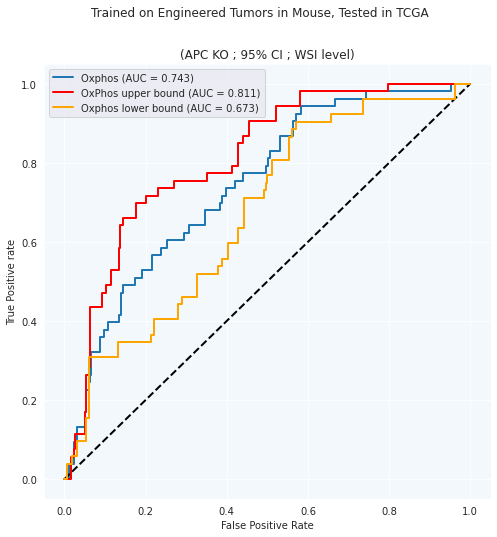

In [86]:
'Compute and show ROC curves with confidence intervals on data (APC - OxPhos)'

res, fpr_mean, tpr_mean, auc_mean = generate_confidence_roc('APC', 'OxPhos')
fpr_lower, tpr_lower, fpr_upper, tpr_upper = get_bounds(res)

plt.figure(figsize=(8,8))
ax = plt.axes()
plt.title("(APC KO ; 95% CI ; WSI level)")
plt.suptitle('Trained on Engineered Tumors in Mouse, Tested in TCGA')

ax.set_facecolor("#f2f8fb")
plt.plot(fpr_mean, tpr_mean, lw=2, label = 'Oxphos (AUC = '+ '{:.3f}'.format((auc_mean)) + ')') 
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
auc_upper = metrics.auc(fpr_upper, tpr_upper)
auc_lower = metrics.auc(fpr_lower, tpr_lower)
plt.plot(fpr_upper, tpr_upper, lw=2, color = 'red', label='OxPhos upper bound (AUC = '+ '{:.3f}'.format((auc_upper)) + ')') 
plt.plot(fpr_lower, tpr_lower, lw=2, color = 'orange', label='Oxphos lower bound (AUC = '+ '{:.3f}'.format((auc_lower)) + ')') 


#plt.fill_between(fpr_lower[class_], tpr_lower[class_], tpr_upper[class_], color="lightblue") 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')

plt.savefig('../results/rocs_ci_apc_oxphos_wsi.pdf');

Original ROC area: 0.632


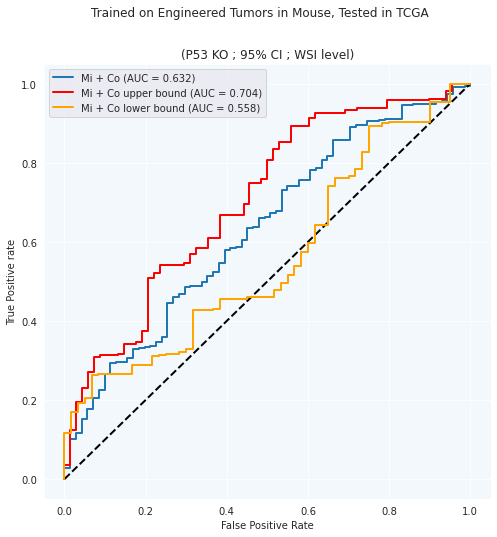

In [88]:
'Compute and show ROC curves with confidence intervals on data (P53 - MITF_Low_Common)'

res, fpr_mean, tpr_mean, auc_mean = generate_confidence_roc('P53', 'MITF_Co')
fpr_lower, tpr_lower, fpr_upper, tpr_upper = get_bounds(res)

plt.figure(figsize=(8,8))
ax = plt.axes()
plt.title("(P53 KO ; 95% CI ; WSI level)")
plt.suptitle('Trained on Engineered Tumors in Mouse, Tested in TCGA')

ax.set_facecolor("#f2f8fb")
plt.plot(fpr_mean, tpr_mean, lw=2, label = 'Mi + Co (AUC = '+ '{:.3f}'.format((auc_mean)) + ')') 
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
auc_upper = metrics.auc(fpr_upper, tpr_upper)
auc_lower = metrics.auc(fpr_lower, tpr_lower)
plt.plot(fpr_upper, tpr_upper, lw=2, color = 'red', label='Mi + Co upper bound (AUC = '+ '{:.3f}'.format((auc_upper)) + ')') 
plt.plot(fpr_lower, tpr_lower, lw=2, color = 'orange', label='Mi + Co lower bound (AUC = '+ '{:.3f}'.format((auc_lower)) + ')') 


#plt.fill_between(fpr_lower[class_], tpr_lower[class_], tpr_upper[class_], color="lightblue") 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')

plt.savefig('../results/rocs_ci_p53_mico_wsi.pdf');

Original ROC area: 0.515


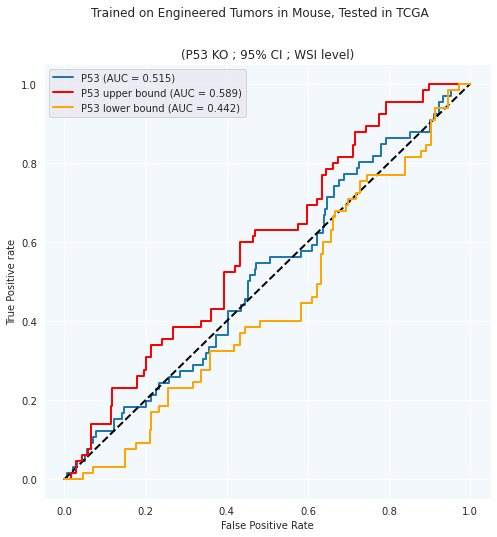

In [91]:
'Compute and show ROC curves with confidence intervals on data (P53 - P53)'

res, fpr_mean, tpr_mean, auc_mean = generate_confidence_roc('P53', 'P53')
fpr_lower, tpr_lower, fpr_upper, tpr_upper = get_bounds(res)

plt.figure(figsize=(8,8))
ax = plt.axes()
plt.title("(P53 KO ; 95% CI ; WSI level)")
plt.suptitle('Trained on Engineered Tumors in Mouse, Tested in TCGA')

ax.set_facecolor("#f2f8fb")
plt.plot(fpr_mean, tpr_mean, lw=2, label = 'P53 (AUC = '+ '{:.3f}'.format((auc_mean)) + ')') 
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
auc_upper = metrics.auc(fpr_upper, tpr_upper)
auc_lower = metrics.auc(fpr_lower, tpr_lower)
plt.plot(fpr_upper, tpr_upper, lw=2, color = 'red', label='P53 upper bound (AUC = '+ '{:.3f}'.format((auc_upper)) + ')') 
plt.plot(fpr_lower, tpr_lower, lw=2, color = 'orange', label='P53 lower bound (AUC = '+ '{:.3f}'.format((auc_lower)) + ')') 


#plt.fill_between(fpr_lower[class_], tpr_lower[class_], tpr_upper[class_], color="lightblue") 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')

plt.savefig('../results/rocs_ci_p53_p53_wsi.pdf');

Original ROC area: 0.530


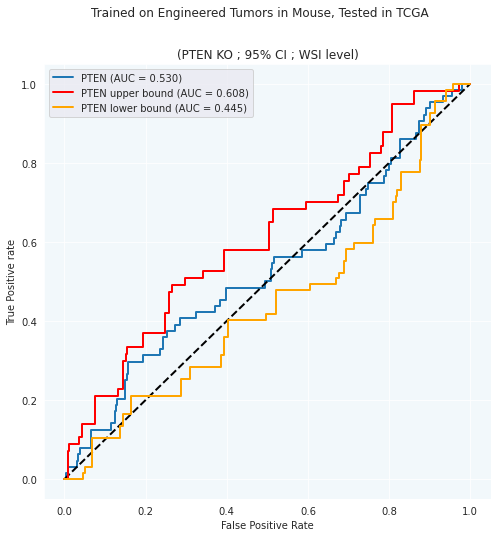

In [92]:
'Compute and show ROC curves with confidence intervals on data (PTEN - PTEN)'

res, fpr_mean, tpr_mean, auc_mean = generate_confidence_roc('PTEN', 'PTEN')
fpr_lower, tpr_lower, fpr_upper, tpr_upper = get_bounds(res)

plt.figure(figsize=(8,8))
ax = plt.axes()
plt.title("(PTEN KO ; 95% CI ; WSI level)")
plt.suptitle('Trained on Engineered Tumors in Mouse, Tested in TCGA')

ax.set_facecolor("#f2f8fb")
plt.plot(fpr_mean, tpr_mean, lw=2, label = 'PTEN (AUC = '+ '{:.3f}'.format((auc_mean)) + ')') 
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
auc_upper = metrics.auc(fpr_upper, tpr_upper)
auc_lower = metrics.auc(fpr_lower, tpr_lower)
plt.plot(fpr_upper, tpr_upper, lw=2, color = 'red', label='PTEN upper bound (AUC = '+ '{:.3f}'.format((auc_upper)) + ')') 
plt.plot(fpr_lower, tpr_lower, lw=2, color = 'orange', label='PTEN lower bound (AUC = '+ '{:.3f}'.format((auc_lower)) + ')') 


#plt.fill_between(fpr_lower[class_], tpr_lower[class_], tpr_upper[class_], color="lightblue") 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')

plt.savefig('../results/rocs_ci_pten_pten_wsi.pdf');

Original ROC area: 0.578


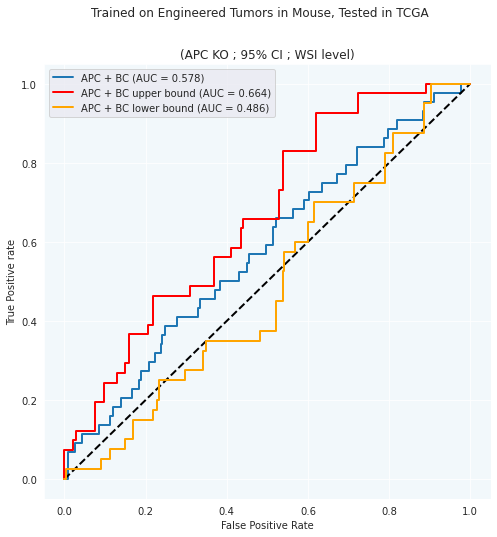

In [93]:
'Compute and show ROC curves with confidence intervals on data (APC - APC_CTNNB1)'

res, fpr_mean, tpr_mean, auc_mean = generate_confidence_roc('APC', 'APC_BC')
fpr_lower, tpr_lower, fpr_upper, tpr_upper = get_bounds(res)

plt.figure(figsize=(8,8))
ax = plt.axes()
plt.title("(APC KO ; 95% CI ; WSI level)")
plt.suptitle('Trained on Engineered Tumors in Mouse, Tested in TCGA')

ax.set_facecolor("#f2f8fb")
plt.plot(fpr_mean, tpr_mean, lw=2, label = 'APC + BC (AUC = '+ '{:.3f}'.format((auc_mean)) + ')') 
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
auc_upper = metrics.auc(fpr_upper, tpr_upper)
auc_lower = metrics.auc(fpr_lower, tpr_lower)
plt.plot(fpr_upper, tpr_upper, lw=2, color = 'red', label='APC + BC upper bound (AUC = '+ '{:.3f}'.format((auc_upper)) + ')') 
plt.plot(fpr_lower, tpr_lower, lw=2, color = 'orange', label='APC + BC lower bound (AUC = '+ '{:.3f}'.format((auc_lower)) + ')') 


#plt.fill_between(fpr_lower[class_], tpr_lower[class_], tpr_upper[class_], color="lightblue") 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')

plt.savefig('../results/rocs_ci_apc_apcbc_wsi.pdf');